<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Log" data-toc-modified-id="Log-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Log</a></span></li></ul></li><li><span><a href="#Pickles" data-toc-modified-id="Pickles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pickles</a></span><ul class="toc-item"><li><span><a href="#Everything" data-toc-modified-id="Everything-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Everything</a></span></li><li><span><a href="#Subset" data-toc-modified-id="Subset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Subset</a></span></li><li><span><a href="#Read-data-from-pickled-df-(not-in-use-due-to-tensor-dtype-bug)" data-toc-modified-id="Read-data-from-pickled-df-(not-in-use-due-to-tensor-dtype-bug)-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read data from pickled df (not in use due to tensor dtype bug)</a></span></li></ul></li><li><span><a href="#DataLoaders" data-toc-modified-id="DataLoaders-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>DataLoaders</a></span><ul class="toc-item"><li><span><a href="#New-method" data-toc-modified-id="New-method-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>New method</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Architecture" data-toc-modified-id="Architecture-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Architecture</a></span></li><li><span><a href="#Loss" data-toc-modified-id="Loss-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Loss</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Working-With-a-Batch" data-toc-modified-id="Working-With-a-Batch-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Working With a Batch</a></span></li></ul></div>

## Log

Video: https://www.youtube.com/watch?v=0frKXR-2PBY

- 2020-10-27 (Tues): Started implementing Jeremy's solution w/ anchor boxes in 2018.9. Made progress. Left off video at 57:49.
- 2020-11-05 (Thurs): Discovered bug in reading from pickled dataframe that was causing multilabel tensors to be created as float dtype instead of int dtype.

# Pickles

## Everything

In [ ]:
# from fastai.vision.all import *

# # paths
# path = Path('/home/rory/data/coco2017')
# train_im_dir, valid_im_dir = 'train2017', 'val2017'
# train_json = 'annotations/instances_train2017.json'
# valid_json = 'annotations/instances_val2017.json'

# # get items & annos
# def get_annos(path, anno_file, im_folder):
#     xs, ys = get_annotations(path/anno_file)
#     return L(xs).map(lambda x: path/im_folder/x), ys
# train_paths, train_annos = get_annos(path, train_json, train_im_dir)
# valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
# paths  = train_paths + valid_paths
# annos  = train_annos + valid_annos
# bboxes = [a[0] for a in annos]
# lbls   = [a[1] for a in annos]

# # create df and pkl
# df = pd.DataFrame({
#     "path": paths,
#     "lbl":  lbls,
#     "bbox": bboxes,
#     "is_valid": [0]*len(train_files) + [1]*len(valid_files),
#     "n_items": L(len(l) for l in lbls)
#     })
# df.to_pickle(path/'20201027_coco_df.pkl')

# df.head(1)

NameError: name 'train_files' is not defined

## Subset

In [ ]:
# from fastai.vision.all import *
    
    
# # paths
# path = Path('/home/rory/data/coco2017')
# train_im_dir, valid_im_dir = 'train2017', 'val2017'
# train_json = 'annotations/instances_train2017.json'
# valid_json = 'annotations/instances_val2017.json'

# # get items & annos
# def get_annos(path, anno_file, im_folder):
#     xs, ys = get_annotations(path/anno_file)
#     return L(xs).map(lambda x: path/im_folder/x), ys
# train_files, train_annos = get_annos(path, train_json, train_im_dir)
# valid_files, valid_annos = get_annos(path, valid_json, valid_im_dir)
# annos = train_annos + valid_annos
# bboxes = L(L(b) for b,l in annos)
# lbls   = L(L(l) for b,l in annos)

# # get label subset
# def flatten(l):
#     def _recur(l,res):
#         for o in l:
#             if   isinstance(o,list): _recur(o,res)
#             elif isinstance(o,L)   : _recur(o,res)
#             else: res.append(o)
#         return res
#     return _recur(l, L())
# lbls_flat = flatten(lbls)
# def get_count(lbl): return len(lbls_flat.filter(lambda x: x==lbl))
# lbls_sorted = sorted(lbls_flat.unique(), key=get_count, reverse=True)
# lbl_cts = [(l, get_count(l)) for l in lbls_sorted]
# lbl_ss = [l for l,c in lbl_cts if 5000<c<30000]
# lbl_ss.remove('traffic light')
# lbl_ss.remove('motorcycle')
# lbl_ss.remove('bus')

# # get subset items & annos
# ss_idxs   = [[o in lbl_ss for o in l] for l in lbls]
# ss_lbls   = [list(o[i]) for o,i in zip(lbls,ss_idxs)]
# ss_bboxes = [list(o[i]) for o,i in zip(bboxes,ss_idxs)]
# ss_obj    = [len(l) for l in ss_lbls]

# # create df
# df = pd.DataFrame({
#     "path"  : train_files + valid_files,
#     "lbl"   : ss_lbls,
#     "bbox"  : ss_bboxes,
#     "n_obj" : ss_obj
#     })

# # remove rows w/ 4+ objects per im
# # reduce value counts to a max of 2*min_vc
# too_many = 8
# rng = list(range(too_many))
# cts = list(df['n_obj'].value_counts())[:too_many]
# minv = min(cts)
# zipd = list(zip(*[rng,cts]))
# zipd[0] = (0, minv) # limit ims w/zero objs
# df = pd.concat([df[df['n_obj']==i].sample(n=min(s,minv*2)) for i,s in zipd])

# # create pkl
# df.to_pickle(path/'20201029_coco_ss_df.pkl')

## Read data from pickled df (not in use due to tensor dtype bug)

In [ ]:
# from fastai.vision.all import *


# ### Params ###
# im_size    = 224
# batch_size = 64
# path       = Path('/home/rory/data/coco2017')
# valid_pct  = .10


# ### Items ###
# df = pd.read_pickle(path/'20201029_coco_ss_df.pkl')
# # get items
# def get_cols(df,cols): return [df[c].to_list() for c in cols]
# paths, bboxes, lbls  = get_cols(df, ['path', 'bbox', 'lbl'])
# p2b = {p:b for p,b in zip(paths,bboxes)}
# p2l = {p:l for p,l in zip(paths,lbls)}
# def get_bbox(p): return p2b[p]
# def get_lbl(p):  return p2l[p]


# ### DataBlock & DataLoaders ###
# db = DataBlock(
#     blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
#     get_y=[get_bbox, get_lbl],
#     splitter=RandomSplitter(valid_pct),
#     item_tfms=Resize(im_size, method='squish'),
#     batch_tfms=Normalize.from_stats(*imagenet_stats),
#     n_inp=1)
# dls = db.dataloaders(paths)

# DataLoaders

In [ ]:
from fastai.vision.all import *


### Params ###
im_size    = 224
batch_size = 64
valid_pct  = .10
subset_pct = .3

# paths
path = Path('/home/rory/data/coco2017')
train_im_dir, valid_im_dir = 'train2017', 'val2017'
train_json = 'annotations/instances_train2017.json'
valid_json = 'annotations/instances_val2017.json'


### Get Items ###
def get_annos(path, anno_file, im_folder):
    xs, ys = get_annotations(path/anno_file)
    return L(xs).map(lambda x: path/im_folder/x), ys
train_paths, train_annos = get_annos(path, train_json, train_im_dir)
valid_paths, valid_annos = get_annos(path, valid_json, valid_im_dir)
paths = train_paths + valid_paths
annos = train_annos + valid_annos
p2a = {p:b for p,b in zip(paths,annos)}
def get_bbox(p): return p2a[p][0]
def get_lbl(p):  return p2a[p][1]


### DataBlock & DataLoaders ###
db = DataBlock(
    blocks=[ImageBlock, BBoxBlock, BBoxLblBlock],
    get_y=[get_bbox, get_lbl],
    splitter=RandomSplitter(valid_pct),
    item_tfms=Resize(im_size, method='squish'),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    n_inp=1)
subset = paths.shuffle()[0:int(len(paths)*subset_pct)]
dls = db.dataloaders(subset)


### Inspection (IMPORTANT) ###
print("Size of train data:",len(dls.train.items))
print("Size of valid data:",len(dls.valid.items))
for i,t in enumerate(dls.one_batch()):
    print(f"batch[{i}]:",'\t',t.dtype,'\t',t.shape)

Size of train data: 32999
Size of valid data: 3666
batch[0]: 	 torch.float32 	 torch.Size([64, 3, 224, 224])
batch[1]: 	 torch.float32 	 torch.Size([64, 21, 4])
batch[2]: 	 torch.int64 	 torch.Size([64, 21])


# Model

## Architecture

In [ ]:
# 42:00
class StdConv(Module):
    def __init__(self, nin, nout, stride=2, drop=0.1):
        super().__init__()
        self.conv = nn.Conv2d(nin, nout, 3, stride=stride, padding=1)
        self.bn = nn.BatchNorm2d(nout)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x): return self.drop(self.bn(F.relu(self.conv(x))))

def flatten_conv(x,k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2) # loss expects flat tensor

class OutConv(Module):
    # output is two conv layers (instead of one linear layer)
    def __init__(self, k, nin, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(nin, 4*k, 3, padding=1)              # bbs
        self.oconv2 = nn.Conv2d(nin, len(dls.vocab)*k, 3, padding=1) # lbls
        self.oconv2.bias.data.zero_().add_(bias)
        
    def forward(self, x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]

class SSD_Head(Module):
    def __init__(self, k, bias):
        super().__init__()
        self.drop = nn.Dropout(0.25)
        self.sconv0 = StdConv(512,256, stride=1)
#         self.sconv1 = StdConv(256,256)
        self.sconv1 = StdConv(256,256)
        self.out = OutConv(k, 256, bias)
        
    def forward(self, x):
        x = self.drop(F.relu(x))
        x = self.sconv0(x)
#         x = self.sconv1(x)
        x = self.sconv1(x)
        return self.out(x)

class Custom_Module(Module):
    def __init__(self, body, head):
        self.body, self.head = body, head
        
    def forward(self, x):
        return self.head(self.body(x))

## Loss

In [ ]:
### Anchors ###
def create_anchors(k=1, subdivs=4, device='cuda'):
    box_size = 1/subdivs
    anc_offset = box_size*.5
    anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, subdivs), subdivs)
    anc_y = np.tile(  np.linspace(anc_offset, 1-anc_offset, subdivs), subdivs)
    anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
    anc_hws = np.array([[box_size,box_size] for i in range(subdivs**2)])
    anchors = torch.cat((tensor(anc_ctrs), tensor(anc_hws)), axis=1)
    box_size = tensor(np.array([box_size]), requires_grad=False).unsqueeze(1)
    return anchors.to(device), box_size.to(device)
anchors, box_size = create_anchors()

def create_anchor_boxes(ctr, hw):
    return 2*torch.cat((tensor(ctr-hw/2), tensor(ctr+hw/2)), axis=1)-1
anchor_boxes = create_anchor_boxes(anchors[:,:2], anchors[:,2:])



### BCE Loss ###
def one_hot_embedding(lbls, n_cls):
    return torch.eye(n_cls)[lbls.data.long()]

class BCE_Loss(nn.Module): # 1:05:35
    def __init__(self, n_cls):
        super().__init__()
        self.n_cls = n_cls
        
    def forward(self, act_lbl, targ_lbl):
        a = act_lbl[:,1:]
        t = one_hot_embedding(targ_lbl, self.n_cls)
        t = tensor(t[:,1:].contiguous()).type_as(a)
        return F.binary_cross_entropy_with_logits(a,t,None,reduction='sum')/self.n_cls

    
    
### IOU ###
def intersxn(b1,b2):
    x1 = torch.max((b1)[:,None,0], (b2)[None,:,0])
    y1 = torch.max((b1)[:,None,1], (b2)[None,:,1])
    x2 = torch.min((b1)[:,None,2], (b2)[None,:,2])
    y2 = torch.min((b1)[:,None,3], (b2)[None,:,3])
    return torch.clamp((x2-x1), min=0) * torch.clamp((y2-y1), min=0)

def area(b):
    return (b[:,2]-b[:,0]) * (b[:,3]-b[:,1])

def get_iou(b1, b2):
    inter = intersxn(b1,b2)
    union = area(b1).unsqueeze(1) + area(b2).unsqueeze(0) - inter
    return inter / union



### SSD Loss ##
def remove_padding(bb, lbl): # 1:11:10
    bb = bb.view(-1,4)
    padding = (bb[:,2]-bb[:,0])==0
    return bb[~padding],lbl[~padding]

def adjust_anchor_boxes(act_bb, anchors, box_size):
    acts = torch.tanh(act_bb) # scale acts 
    ctrs = anchors[:,:2] + (acts[:,:2]/2 * box_size) # move ctrs by up to box_size/2
    hws  = anchors[:,2:] * (acts[:,2:]/2+1)
    return create_anchor_boxes(ctrs, hws)

def get_targ_idx(ious):
    max_iou_per_bb, anc_idxs = ious.max(1)
    max_iou_per_anc, bb_idxs = ious.max(0)
    max_iou_per_anc[anc_idxs] = 1.99
    for i,iou in enumerate(anc_idxs): bb_idxs[iou] = i
    return max_iou_per_anc, bb_idxs

def ssd_item_loss(act_bb, act_lbl, bb, lbl): # 1:11:30
    bb, lbl = remove_padding(bb, lbl)
    pred_bb = adjust_anchor_boxes(act_bb, anchors, box_size)
    ious = get_iou(bb.data, anchor_boxes.data)
    anc_ious, targ_idx = get_targ_idx(ious)
    targ_lbl = lbl[targ_idx]
    above_thresh = anc_ious > 0.4
    assigned_idx = torch.nonzero(above_thresh)[:,0]
    targ_lbl[~above_thresh] = 0
    targ_bb = bb[targ_idx]
    # loss functions
    bb_loss = ((pred_bb[assigned_idx] - targ_bb[assigned_idx]).abs()).mean()
    lbl_loss = loss_f(act_lbl, targ_lbl)
    return bb_loss, lbl_loss

def ssd_loss(acts, bbs, lbls):
    sum_bb_loss, sum_lbl_loss = 0., 0.
    for act_bb,act_lbl,bb,lbl in zip(*acts, bbs, lbls):
        bb_loss,lbl_loss = ssd_item_loss(act_bb,act_lbl,bb,lbl)
        sum_bb_loss += bb_loss
        sum_lbl_loss += lbl_loss
    return sum_bb_loss + sum_lbl_loss

# Training

In [ ]:
k=1
head_reg4 = SSD_Head(k, -3.)
body = create_body(resnet34, pretrained=True)
mod = Custom_Module(body, head_reg4)

loss_f = BCE_Loss(len(dls.vocab))

learner = Learner(dls, mod, loss_func = ssd_loss)
learner.freeze()

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.001737800776027143)

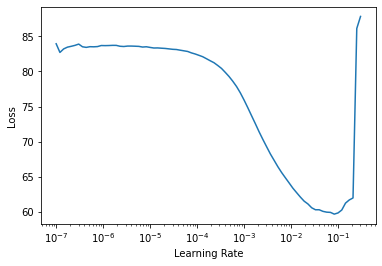

In [ ]:
learner.lr_find()

# Working With a Batch

In [ ]:
def show_bb(im,bb,lbl=None,sz=224,figsize=[5,5],color='white',ctx=None,use_vocab=True,title=None):
    bboxes = TensorBBox((bb+1)*sz//2)
    if lbl!=None:
        if use_vocab==True:
            try: label = dls.vocab[lbl]
            except: label = lbl
        else: label = lbl
        lbboxes = LabeledBBox(bboxes, label)
    if ctx==None: ctx=show_image(im, figsize=figsize, title=title)
    else: show_image(im, figsize=figsize, title=title, ctx=ctx)
    if lbl!=None: lbboxes.show(ctx=ctx) # draw white bboxes and lbls
    bboxes.show(ctx=ctx, color=color) # draw colored bboxes over white bboxes
    return ctx

JH uses b_clasi and b_bboxi for his model outputs (acts), and bbox and clas for his batch outputs.

In [ ]:
# grab batch and acts (52m)
batch = dls.one_batch()
b_ims, b_bbs, b_lbls = batch

In [ ]:
# grab acts
learner.model.eval()
learner.model.cuda()
acts = learner.model(b_ims)
act_bbs, act_lbls = acts

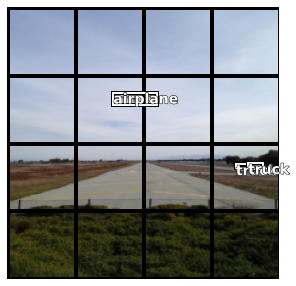

In [ ]:
# grab single im and its b_ & a_ bbox,lbl
idx=3

bb  = b_bbs[idx]
lbl = b_lbls[idx]

act_bb  = act_bbs[idx]
act_lbl = act_lbls[idx]

decoded_batch = dls.decode(batch)
im = decoded_batch[0][idx]

# show im w/ targ, ancs
ctx = show_bb(im, anchor_boxes, sz=im_size, color='black')
show_bb(im, bb, lbl, sz=im_size, ctx=ctx);

Interpreting the activations:
- `a_bbox` has 16 sets of 4 → 16 bboxes
- `a_lbl` has 16 sets of 51 → 16 sets 51 probs (1 prob per item in dls.vocab)

In [ ]:
bb, lbl

(tensor([[-0.2207, -0.3678,  0.1035, -0.2843],
         [ 0.6874,  0.1528,  0.7743,  0.1855],
         [ 0.7756,  0.1506,  0.8800,  0.1891],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.

In [ ]:
bb, lbl = remove_padding(bb, lbl)
bb, lbl

(tensor([[-0.2207, -0.3678,  0.1035, -0.2843],
         [ 0.6874,  0.1528,  0.7743,  0.1855],
         [ 0.7756,  0.1506,  0.8800,  0.1891]], device='cuda:0'),
 tensor([ 1, 75, 75], device='cuda:0'))

In [ ]:
acts = torch.tanh(act_bb) # scale acts 
acts

tensor([[-0.0556, -0.0846, -0.0076,  0.0416],
        [-0.2327,  0.0260, -0.1926,  0.2061],
        [-0.2514, -0.0407, -0.3315,  0.2111],
        [-0.0667, -0.1395, -0.2915,  0.1028],
        [-0.1700, -0.2928,  0.0278,  0.2126],
        [-0.3300, -0.2728,  0.0331,  0.4671],
        [-0.1598, -0.2055, -0.2945,  0.3873],
        [-0.0854, -0.1304, -0.3179,  0.2054],
        [-0.3465, -0.0973, -0.1581,  0.2130],
        [-0.2106,  0.0406, -0.1469,  0.3431],
        [ 0.0272, -0.1153, -0.2860,  0.2246],
        [ 0.0735, -0.0262, -0.1617,  0.0949],
        [-0.2020, -0.0075, -0.2236, -0.0331],
        [-0.2462, -0.0205, -0.0272, -0.0149],
        [-0.1325, -0.0083, -0.1141,  0.0998],
        [ 0.0170,  0.0610, -0.1479,  0.1125]], device='cuda:0',
       grad_fn=<TanhBackward>)

In [ ]:
acts

tensor([[-0.0556, -0.0846, -0.0076,  0.0416],
        [-0.2327,  0.0260, -0.1926,  0.2061],
        [-0.2514, -0.0407, -0.3315,  0.2111],
        [-0.0667, -0.1395, -0.2915,  0.1028],
        [-0.1700, -0.2928,  0.0278,  0.2126],
        [-0.3300, -0.2728,  0.0331,  0.4671],
        [-0.1598, -0.2055, -0.2945,  0.3873],
        [-0.0854, -0.1304, -0.3179,  0.2054],
        [-0.3465, -0.0973, -0.1581,  0.2130],
        [-0.2106,  0.0406, -0.1469,  0.3431],
        [ 0.0272, -0.1153, -0.2860,  0.2246],
        [ 0.0735, -0.0262, -0.1617,  0.0949],
        [-0.2020, -0.0075, -0.2236, -0.0331],
        [-0.2462, -0.0205, -0.0272, -0.0149],
        [-0.1325, -0.0083, -0.1141,  0.0998],
        [ 0.0170,  0.0610, -0.1479,  0.1125]], device='cuda:0',
       grad_fn=<TanhBackward>)

In [ ]:
ctrs = anchors[:,:2] + (acts[:,:2]/2 * box_size) # move ctrs by up to box_size/2
ctrs

tensor([[0.1181, 0.1144],
        [0.0959, 0.3783],
        [0.0936, 0.6199],
        [0.1167, 0.8576],
        [0.3538, 0.0884],
        [0.3337, 0.3409],
        [0.3550, 0.5993],
        [0.3643, 0.8587],
        [0.5817, 0.1128],
        [0.5987, 0.3801],
        [0.6284, 0.6106],
        [0.6342, 0.8717],
        [0.8497, 0.1241],
        [0.8442, 0.3724],
        [0.8584, 0.6240],
        [0.8771, 0.8826]], device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
hws  = anchors[:,2:] * (acts[:,2:]/2+1)

In [ ]:
pred_bb = create_anchor_boxes(ctrs, hws)
pred_bb

tensor([[-1.0129, -1.0264, -0.5148, -0.5160],
        [-1.0341, -0.5193, -0.5822,  0.0323],
        [-1.0214, -0.0366, -0.6043,  0.5162],
        [-0.9803,  0.4523, -0.5531,  0.9780],
        [-0.5460, -1.0998, -0.0390, -0.5466],
        [-0.5866, -0.6266, -0.0784, -0.0098],
        [-0.5031, -0.0998, -0.0768,  0.4970],
        [-0.4816,  0.4417, -0.0611,  0.9931],
        [-0.0669, -1.0509,  0.3936, -0.4977],
        [-0.0343, -0.5327,  0.4290,  0.0530],
        [ 0.0426, -0.0569,  0.4711,  0.4993],
        [ 0.0386,  0.4816,  0.4982,  1.0053],
        [ 0.4774, -0.9977,  0.9215, -0.5060],
        [ 0.4419, -0.5033,  0.9351, -0.0070],
        [ 0.4811, -0.0145,  0.9526,  0.5104],
        [ 0.5227,  0.5012,  0.9858,  1.0293]], device='cuda:0',
       grad_fn=<SubBackward0>)

In [ ]:
ious = get_iou(bb.data, anchor_boxes.data)
ious

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0712, 0.0000, 0.0000, 0.0000,
         0.0322, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0114, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0161, 0.0000]],
       device='cuda:0')

In [ ]:
anc_ious, targ_idx = get_targ_idx(ious)
anc_ious, targ_idx

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.9900, 0.0000, 0.0000, 0.0000,
         0.0322, 0.0000, 0.0000, 0.0000, 0.0000, 1.9900, 0.0000],
        device='cuda:0'),
 tensor([2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2], device='cuda:0'))

In [ ]:
targ_lbl = lbl[targ_idx]
targ_lbl

tensor([75, 75, 75, 75, 75,  1, 75, 75, 75,  1, 75, 75, 75, 75, 75, 75],
       device='cuda:0')

In [ ]:
above_thresh = anc_ious > 0.4
above_thresh

tensor([False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False,  True, False], device='cuda:0')

In [ ]:
assigned_idx = torch.nonzero(above_thresh)[:,0]
assigned_idx

tensor([ 5, 14], device='cuda:0')

In [ ]:
targ_lbl[~above_thresh] = 0
targ_lbl

tensor([ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0, 75,  0],
       device='cuda:0')

In [ ]:
targ_bb = bb[targ_idx]
targ_bb

tensor([[ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [-0.2207, -0.3678,  0.1035, -0.2843],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [-0.2207, -0.3678,  0.1035, -0.2843],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891],
        [ 0.7756,  0.1506,  0.8800,  0.1891]], device='cuda:0')

In [ ]:
bb_loss = ((pred_bb[assigned_idx] - targ_bb[assigned_idx]).abs()).mean()
bb_loss

tensor(0.2418, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
lbl_loss = loss_f(act_lbl, targ_lbl)
lbl_loss

tensor(0.8473, device='cuda:0', grad_fn=<DivBackward0>)